# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Import the data as a pandas dataframe

In [4]:
path_1 = Path('/Users/oleseifert/Documents/Techlabs/SoSe-21-Team-10_Main/data/raw')
df = pd.read_csv(path_1.joinpath('train_timeseries.csv'), index_col='date', parse_dates=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19300680 entries, 2000-01-01 to 2016-12-31
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   PRECTOT      float64
 2   PS           float64
 3   QV2M         float64
 4   T2M          float64
 5   T2MDEW       float64
 6   T2MWET       float64
 7   T2M_MAX      float64
 8   T2M_MIN      float64
 9   T2M_RANGE    float64
 10  TS           float64
 11  WS10M        float64
 12  WS10M_MAX    float64
 13  WS10M_MIN    float64
 14  WS10M_RANGE  float64
 15  WS50M        float64
 16  WS50M_MAX    float64
 17  WS50M_MIN    float64
 18  WS50M_RANGE  float64
 19  score        float64
dtypes: float64(19), int64(1)
memory usage: 3.0 GB


In [5]:
df_cut = df.iloc[0:366,:]

## First Year (2000) is imported as 'df_cut'

### Starting with some first explorations of the dataset. I will first do some plots of the columns.

# Description of Columns:

**fips** = US county FIPS code. see: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_0136 \
**date** = Date \
**PRECTOT** = Precipitation (mm day-1) \
**PS** = Surface Pressure (kPa) \
**QV2M** = Specific Humidity at 2 Meters (g/kg) \
**T2M** = Temperature at 2 Meters (C) \
**T2MDEW** = Dew/Frost Point at 2 Meters (C) \
**T2MWET** = Wet Bulb Temperature at 2 Meters (C) \
**T2M_MAX** = Maximum Temperature at 2 Meters (C) \
**T2M_MIN** = Minimum Temperature at 2 Meters (C) \
**T2M_RANGE** = Temperature Range at 2 Meters (C) \
**TS** = Earth Skin Temperature (C) \
**WS10M** = Wind Speed at 10 Meters (m/s) \
**WS10M_MAX** = Maximum Wind Speed at 10 Meters (m/s) \
**WS10M_MIN** = Minimum Wind Speed at 10 Meters (m/s) \
**WS10M_RANGE** = Wind Speed Range at 10 Meters (m/s) \
**WS50M** = Wind Speed at 50 Meters (m/s) \
**WS50M_MAX** = Maximum Wind Speed at 50 Meters (m/s) \
**WS50M_MIN** = Minimum Wind Speed at 50 Meters (m/s) \
**WS50M_RANGE** = Wind Speed Range at 50 Meters (m/s) \
**score** = Measure of drought ranging from 0 (no drought) to 5 (D4, see description).

# Trying to build an ARIMA model

In [6]:
from statsmodels.tsa.arima_model import ARIMA

## Figure out order for ARIMA

In [7]:
from pmdarima import auto_arima
# ignore the warinings
import warnings
warnings.filterwarnings("ignore")

In [8]:
stepwise_fit= auto_arima(df_cut['PRECTOT'], trace=True, suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2346.750, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2383.835, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2346.366, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2341.852, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2444.561, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2343.836, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2343.840, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2345.851, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2377.506, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.735 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1167.926
Date:                Wed, 16 Jun 2021   AIC                           2341.852
Time:                        20:57:35   BIC                           2353.560
Sample:                             0   HQIC                          2346.504
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6958      0.765      3.523      0.000       1.196       4.196
ma.L1          0.3591      0.030     11.856      0.000       0.300       0.418
sigma2        34.5999      1.425     24.289      0.000      31.808      37.392
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4059.21
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             3.22
Prob(H) (two-sided):                  0.67   Kurtosis:                        17.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split Data into Training and Test Data 
**(Using a size of 70% for training and 30% for the test)**

In [10]:
train= df_cut.iloc[0:256]
test= df_cut.iloc[256:]

In [16]:
test.shape

(110, 20)

## Train the model

In [11]:
model=ARIMA(train['PRECTOT'], order=(0,0,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                PRECTOT   No. Observations:                  256
Model:                     ARMA(0, 1)   Log Likelihood                -793.373
Method:                       css-mle   S.D. of innovations              5.365
Date:                Wed, 16 Jun 2021   AIC                           1592.745
Time:                        21:06:06   BIC                           1603.381
Sample:                    01-01-2000   HQIC                          1597.023
                         - 09-12-2000                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5092      0.456      5.506      0.000       1.616       3.402
ma.L1.PRECTOT     0.3604      0.064      5.620      0.000       0.235       0.486
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.7745           +0.0000j            2.7745            0.5000
-----------------------------------------------------------------------------
"""

## Make predictions on the training set

In [12]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start, end=end, typ='levels')
print(pred)

2000-09-13    2.300090
2000-09-14    2.509227
2000-09-15    2.509227
2000-09-16    2.509227
2000-09-17    2.509227
                ...   
2000-12-27    2.509227
2000-12-28    2.509227
2000-12-29    2.509227
2000-12-30    2.509227
2000-12-31    2.509227
Freq: D, Length: 110, dtype: float64


<AxesSubplot:xlabel='date'>

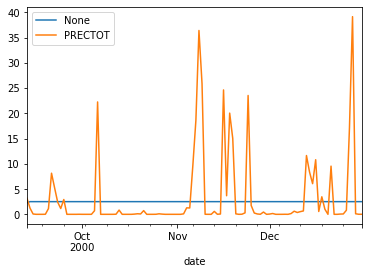

In [15]:
pred.plot(legend=True)
test['PRECTOT'].plot(legend=True)

I tried to build an ARIMA model. I just followed the steps of a youtube tutorial. I didn't put any time in understanding the model, because I didn't had the time to. I'm not sure where I went wrong, due to my understanding of the model. 